In [54]:
import numpy as np
import GCRCatalogs
import matplotlib.pyplot as plt
import scipy.integrate

In [65]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, join
import GCRCatalogs
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
    
import healpy

In [3]:
extragalactic_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

In [4]:
healpix_pixels = extragalactic_cat.get_catalog_info()['healpix_pixels']

In [5]:
healpix_selected = healpix_pixels[2]

In [6]:
healpix_selected

9687

In [9]:
# get list of massive halos in a given redshift and mass range
mmin = 1.e14 # Msun
zmin = 0.3
zmax = 0.4
massive_halos = extragalactic_cat.get_quantities(['halo_mass','hostHaloMass','redshift','ra', 'dec', 'halo_id'],
                                                 filters=[f'halo_mass > {mmin}','is_central==True',
                                                          f'redshift>{zmin}', f'redshift<{zmax}'], native_filters=['healpix_pixel == ' + str(healpix_selected)])
N_cl = len(massive_halos['halo_mass'])
print(f'There are {N_cl} clusters in this mass and redshift range')

There are 11 clusters in this mass and redshift range


In [10]:
select = massive_halos['halo_mass'] == np.max(massive_halos['halo_mass'])

ra_cl = massive_halos['ra'][select][0]
dec_cl = massive_halos['dec'][select][0]
z_cl = massive_halos['redshift'][select][0]
mass_cl =massive_halos['halo_mass'][select][0]
id_cl = massive_halos['halo_id'][select][0]

In [11]:
ra_min, ra_max = ra_cl - 0.3, ra_cl + 0.3
dec_min, dec_max = dec_cl - 0.3, dec_cl + 0.3
z_min = z_cl + 0.1
mag_i_max = 25

In [12]:
n_points = 300

ra_random, dec_random = np.random.random(n_points)*(ra_max - ra_min) + ra_min, np.random.random(n_points)*(dec_max - dec_min) + dec_min

In [13]:
contiguous_healpix_pixels = np.unique(healpy.ang2pix(32, ra_random, dec_random, nest=False, lonlat=True))

In [14]:
contiguous_healpix_pixels

array([9687])

In [15]:
%%time
coord_filters = ['ra >= {}'.format(ra_min),'ra < {}'.format(ra_max),'dec >= {}'.format(dec_min),'dec < {}'.format(dec_max)]
z_filters = ['redshift >= {}'.format(z_min)]
mag_filters = ['mag_i < {}'.format(mag_i_max)]
gal_cat = extragalactic_cat.get_quantities(['galaxy_id', 'ra', 'dec',
                                            'shear_1', 'shear_2',
                                            'redshift', 'convergence'],
                                           filters=(coord_filters + z_filters + mag_filters), native_filters=['healpix_pixel == ' + str(healpix_selected)])

CPU times: user 19.2 s, sys: 8.66 s, total: 27.9 s
Wall time: 31.6 s


In [16]:
len (gal_cat['ra'])

35664

In [17]:
%%time
cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small_with_photozs_v1')

CPU times: user 2.18 s, sys: 952 ms, total: 3.13 s
Wall time: 4.86 s


In [18]:
%%time
photoz_cat = cat.get_quantities(['photoz_pdf','photoz_mean','photoz_mode','photoz_odds','redshift', 'galaxy_id'],
                            native_filters=['healpix_pixel=='+str(contiguous_healpix_pixels[0])])

CPU times: user 28.8 s, sys: 19.2 s, total: 48.1 s
Wall time: 52.4 s


In [19]:
tab_astropy = Table()

In [20]:
tab_astropy['galaxy_id'] = photoz_cat['galaxy_id']

tab_astropy['photoz_pdf'] =  photoz_cat['photoz_pdf']

tab_astropy['photoz_mean'] =  photoz_cat['photoz_mean']

tab_astropy['photoz_mode'] = photoz_cat['photoz_mode']

tab_astropy['photoz_odds'] = photoz_cat['photoz_odds']

mask = np.isin(tab_astropy['galaxy_id'],np.array(gal_cat['galaxy_id']))

tab_cut = tab_astropy[mask]

In [67]:
cat_complete = join(tab_cut, gal_cat, keys = 'galaxy_id')

In [69]:
cat_complete.colnames

['galaxy_id',
 'photoz_pdf',
 'photoz_mean',
 'photoz_mode',
 'photoz_odds',
 'dec',
 'ra',
 'shear_2',
 'convergence',
 'shear_1',
 'redshift']

In [70]:
z_bins = cat.photoz_pdf_bin_centers

In [71]:
cosmo = clmm.Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)

In [72]:
sigma_crit_1 = 1/cosmo.eval_sigma_crit(z_min, z_bins)

In [73]:
unormed_integral = scipy.integrate.simps(cat_complete['photoz_pdf'] * sigma_crit_1, x=z_bins, axis = 1)
norm = scipy.integrate.simps(cat_complete['photoz_pdf'], x=z_bins, axis = 1)

In [114]:
w_ls_photozs = unormed_integral/norm
w_ls_true = 1/cosmo.eval_sigma_crit(z_min, cat_complete['redshift'])
w_ls_mean = 1/cosmo.eval_sigma_crit(z_min, cat_complete['photoz_mean'])
w_ls_mode = 1/cosmo.eval_sigma_crit(z_min,cat_complete['photoz_mode'])

In [138]:
w_ls_with_photozs = [w_ls_photozs, w_ls_mean, w_ls_mode]
label = [r'$\langle \Sigma_{\rm crit}(z_{\rm cluster}, z)^{-1} \rangle$', r'$\Sigma_{\rm crit}(z_{\rm cluster}, \langle z \rangle)^{-1}$', r'$\Sigma_{\rm crit}(z_{\rm cluster}, z_{\rm mode})^{-1}$']

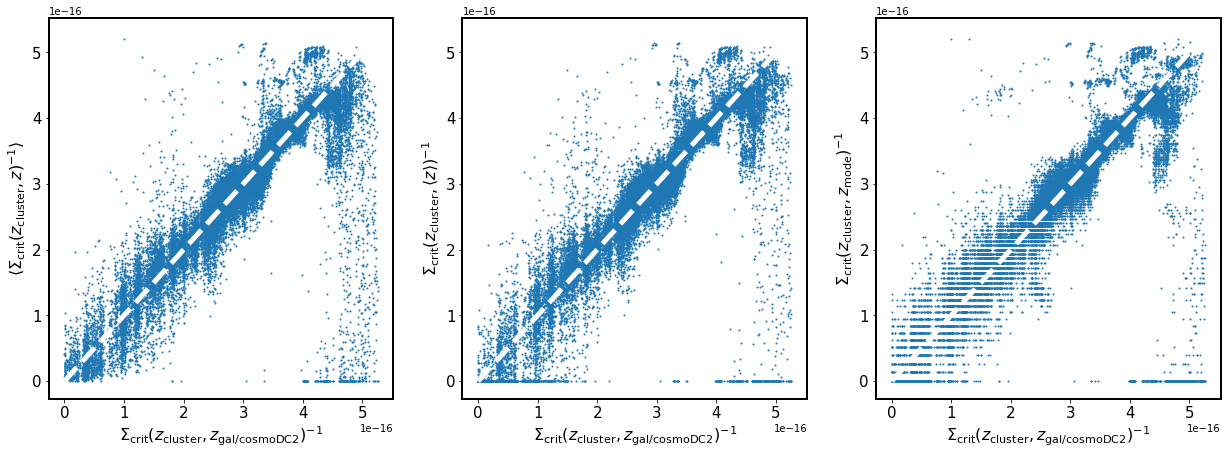

In [139]:
x = np.logspace(np.log10(min(w_ls_true)) ,np.log10(max(w_ls_true)), 100)
fig, axs = plt.subplots(1, 3, figsize = (21,7))
for i in range(3):
    axs[i].scatter(w_ls_true, w_ls_with_photozs[i], s = 1)
    axs[i].plot(x,x, '--w', linewidth = 5)
    axs[i].set_xlabel(r'$\Sigma_{\rm crit}(z_{\rm cluster}, z_{\rm gal/cosmoDC2})^{-1}$', fontsize = 16)
    axs[i].set_ylabel(label[i], fontsize = 16)
    axs[i].tick_params(axis='both', which = 'major', labelsize= 15, zorder = 0)

# Make shear profile

In [141]:
data = clmm.GCData(cat_complete)
cl = clmm.GalaxyCluster('Stack', ra_cl, dec_cl, z_cl, data)

In [154]:
cl.galcat['z'] = cl.galcat['redshift']

In [197]:
theta, g_t, g_x = cl.compute_tangential_and_cross_components(
                                                    shape_component1='shear_1', shape_component2='shear_2', 
                                                  tan_component='et_test', cross_component='ex_test',geometry="flat")

In [208]:
cl.galcat['r'] = cosmo.eval_da(cl.z)*cl.galcat['theta']

In [209]:
cl.galcat.colnames

['galaxy_id',
 'photoz_pdf',
 'photoz_mean',
 'photoz_mode',
 'photoz_odds',
 'dec',
 'ra',
 'shear_2',
 'convergence',
 'shear_1',
 'redshift',
 'theta',
 'shear_t',
 'shear_x',
 'gt',
 'gx',
 'z',
 'sigma_c',
 'et_test',
 'ex_test',
 'r']

In [240]:
cl.galcat['w_ls_true'] = np.array(w_ls_true)
cl.galcat['w_ls_photoz_pdf'] = np.array(w_ls_photozs)
cl.galcat['w_ls_mean'] = np.array(w_ls_mean)

In [241]:
bin_edges = clmm.make_bins(1, 6, nbins=20, method='evenwidth')

In [242]:
radial_bin = [[bin_edges[i], bin_edges[i + 1]] for i in range(len(bin_edges)-1)]

In [297]:
names = ['r', 'DS', 'DS_err']
profile_true = Table(names=names)
profile_pdf = Table(names=names)
profile_mean = Table(names=names)
for i, r_bin in enumerate(radial_bin):
    mask = (cl.galcat['r'] > r_bin[0])*(cl.galcat['r'] < r_bin[1])*(cl.galcat['w_ls_photoz_pdf'] != 0)*(cl.galcat['w_ls_mean'] != 0)
    data_cut = cl.galcat[mask]
    r_mean = np.mean(data_cut['r'])
    ds_true = np.average(data_cut['shear_t']*data_cut['w_ls_true']**(-1), weights = data_cut['w_ls_true']**2)
    ds_true_rms = np.sqrt(np.average((data_cut['shear_t']*data_cut['w_ls_true']**(-1) - ds_true)**2, weights = data_cut['w_ls_true']**2))/np.sqrt(len(data_cut))
    
    ds_photoz_pdf = np.average(data_cut['shear_t']*data_cut['w_ls_photoz_pdf']**(-1), weights = data_cut['w_ls_photoz_pdf']**2)
    ds_photoz_pdf_rms = np.sqrt(np.average((data_cut['shear_t']*data_cut['w_ls_photoz_pdf']**(-1) - ds_photoz_pdf)**2, weights = data_cut['w_ls_photoz_pdf']**2))/np.sqrt(len(data_cut))
    
    ds_mean = np.average(data_cut['shear_t']*data_cut['w_ls_mean']**(-1), weights = data_cut['w_ls_mean']**2)
    ds_mean_rms = np.sqrt(np.average((data_cut['shear_t']*data_cut['w_ls_mean']**(-1) - ds_mean)**2, weights = data_cut['w_ls_mean']**2))/np.sqrt(len(data_cut))
    profile_true.add_row([r_mean, ds_true, ds_true_rms])
    profile_pdf.add_row([r_mean, ds_photoz_pdf,  ds_photoz_pdf_rms])
    profile_mean.add_row([r_mean, ds_mean,  ds_mean_rms])

<ErrorbarContainer object of 3 artists>

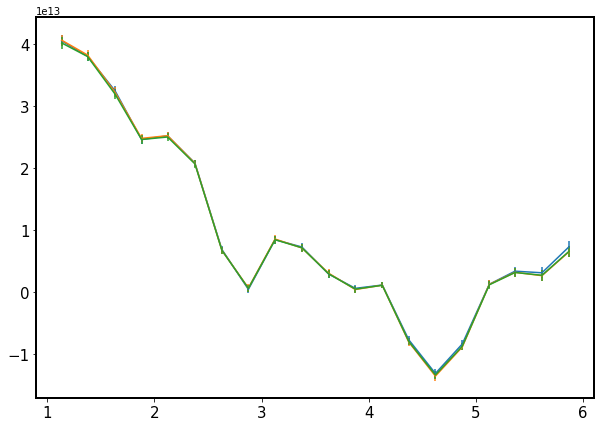

In [301]:
plt.figure(figsize = (10,7))
plt.rcParams['axes.linewidth'] = 2
plt.tick_params(axis='both', which = 'major', labelsize= 15)
plt.errorbar(profile_true['r'], profile_true['DS'], profile_true['DS_err'])
plt.errorbar(profile_true['r'], profile_pdf['DS'], profile_pdf['DS_err'])
plt.errorbar(profile_true['r'], profile_mean['DS'], profile_mean['DS_err'])